In [1]:
import bussilab
import plumed
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas
import MDAnalysis as mda
from MDAnalysis import transformations
from MDAnalysis.analysis import distances
import MDAnalysis.analysis.distances as distances
from MDAnalysis.analysis.base import AnalysisBase

import os

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from skmatter.feature_selection import FPS

%matplotlib inline

In [2]:
start = 0.53 
end = 0.63 

resolution = 10

bin_edges = np.linspace(start, end, resolution + 1)
bin_edges

array([0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63])

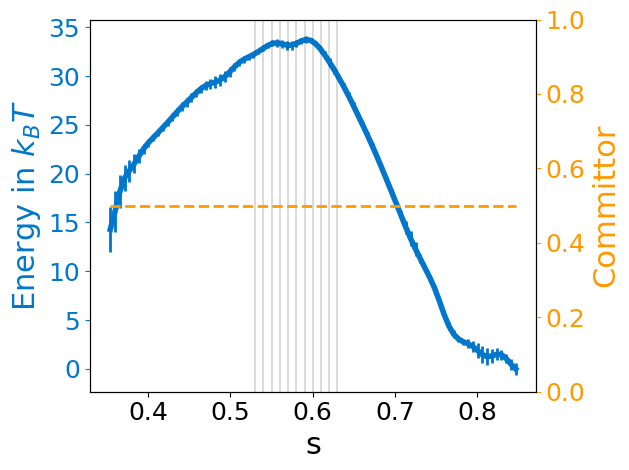

In [3]:
data=np.load("../raw_data/Dialanine/Path2_FES_estimator.npy")
ndx=np.where((data[:,0]>=0.35) & (data[:,0]<=0.85))[0]
fig = plt.figure()
    
plt.errorbar(data[:,0][ndx], data[:,1][ndx]-np.min(data[:,1][ndx]), yerr=data[:,2][ndx], color='#0077cc',linewidth=2)
plt.plot(data[:,0][ndx], data[:,1][ndx]-np.min(data[:,1][ndx]), color='#0077cc',linewidth=4)

plt.ylabel(r'Energy in $k_BT$', color='#0077cc',fontsize=22)
plt.xlabel('s',fontsize=22)

plt.tick_params(axis='y', colors='#0077cc')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)


for bin_edge in bin_edges:
    plt.axvline(x=bin_edge, color='black', linestyle='-', linewidth=0.2)

# Create a twin Axes for the second y-axis
ax2 = plt.gca().twinx()

# Plot the second data on the second y-axis
ax2.hlines(0.5,np.min(data[:,0][ndx]),np.max(data[:,0][ndx]),color='#ff9900',linewidth=2,linestyle='dashed')


ax2.set_ylabel('Committor', color='#ff9900',fontsize=22)
ax2.tick_params(axis='y', colors='#ff9900',labelsize=18)
ax2.set_ylim(0,1)
plt.tight_layout()
plt.show()

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/frohlkin@farma.unige.ch/anaconda3/envs/MLpathcv/lib/libplumedKernel.so" +++


10
100


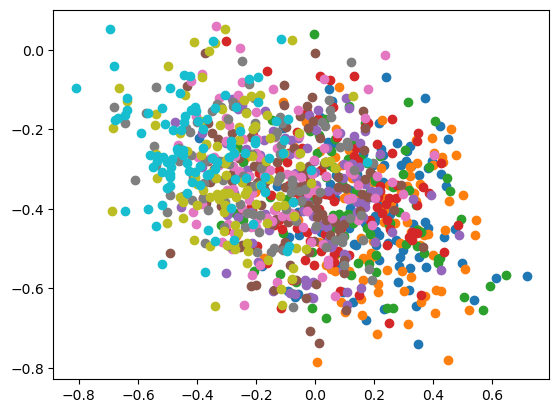

In [4]:
folder='../raw_data/Dialanine/Path2/'

colvar1=plumed.read_as_pandas(folder+"COLVAR_DeepLNE_replica0")
s=colvar1['model.node-0']
phi=colvar1['phi']
psi=colvar1['psi']

all_indices = []
z=colvar1['model.node-1']


for r in range(resolution):
    ndx=np.where((bin_edges[r] < s) & (s < bin_edges[r+1]))[0]
    ndx_z=np.argsort(z[ndx])[:100]
    ndx=ndx[ndx_z]
    plt.scatter(phi[ndx],psi[ndx],alpha=1)
    
    all_indices.append(ndx)
    
print(len(all_indices))
print(len(all_indices[0]))

In [ ]:
!mkdir Committor_OPES

In [ ]:
%%bash
for i in 1 2 3 4 5 6 7 8 9 10
do
    mkdir Committor_OPES/$i
done

In [ ]:
#move the OneOPES replica0 'MD.xtc' into the working directory
!gmx_mpi check -f MD.xtc

In [ ]:
%%bash 
cat > Production.mdp << EOF
; RUN PARAMETERS
integrator               = md
dt                       = 0.002
nsteps                   = 500000000               
nstxout                  = 500000                     
nstvout                  =     
nstlog                   = 500000
nstenergy                = 500000
nstxtcout                = 500000
xtc_grps                 = System     
energygrps               = System       
                                                
;NEIGHBORING SEARCHING PARAMETERS
nstlist                  = 10                   
ns_type                  = Grid                 
                                                                                     
pbc                      = xyz                  
rlist                    = 1.0

;OPTIONS FOR ELECTROSTATICS AND VDW
cutoff-scheme            = Verlet
coulombtype              = PME 
pme_order                = 4                     
fourierspacing           = 0.12 
rcoulomb                 = 1.0
vdw-type                 = Cut-off
rvdw                     = 1.0


;TEMPERATURE COUPLING
tcoupl                   = v-rescale            
tc-grps                  = System
tau_t                    = 0.1
ref_t                    = 300

;DISPERSION CORRECTION
DispCorr                 = EnerPres             

;PRESSURE COUPLING
Pcoupl                   = no                   

continuation             = no
gen_vel                  = yes                   
gen_temp                 = 300
gen_seed                 = -1

;OPTIONS FOR BONDS
lincs_iter               = 1
lincs_order              = 4
constraints              = h-bonds
EOF

In [ ]:
timestep=0.02

In [ ]:
indices_list = []

for i in range(len(all_indices)):
    indices = np.array(all_indices[i]) * timestep
    indices_str = ' '.join(map(str, indices))
    indices_list.append(indices_str)
    
ndx0=indices_list[0]
ndx1=indices_list[1]
ndx2=indices_list[2]
ndx3=indices_list[3]
ndx4=indices_list[4]
ndx5=indices_list[5]
ndx6=indices_list[6]
ndx7=indices_list[7]
ndx8=indices_list[8]
ndx9=indices_list[9]

In [ ]:
%%bash -s "$ndx0" "$ndx1" "$ndx2" "$ndx3" "$ndx4" "$ndx5" "$ndx6" "$ndx7" "$ndx8" "$ndx9"

for j in {1..10}
do

    indices_var=${j}
    indices=$(eval echo \${${indices_var}})
    
    echo ${j}
    echo ${indices_var}
    echo $indices
    
    counter=0
    for i in $indices
    do
        echo 0 | gmx_mpi trjconv -f MD.xtc -s newbox_diala_DESRES -dump $i -o Committor_OPES/${j}/committor_run_$counter.pdb
        gmx_mpi grompp -f Production.mdp -c Committor_OPES/${j}/committor_run_$counter.pdb -p topol.top -n index.ndx -o Committor_OPES/${j}/committor_run_$counter.tpr 
        ((counter++))
    done
    
done

In [ ]:
for i in range(1,11):
    directory_path = "Committor_OPES/%s"%i  # Replace with your actual directory path

    all_files = os.listdir(directory_path)

    tpr_files = [file for file in all_files if file.endswith(".tpr")]


    integers_list = []
    for s in tpr_files:
        integers = [int(match) for match in re.findall(r'\d+', s)]
        integers_list.extend(integers)
    len(integers_list)

    for elem in integers_list:
        lines=[]
        lines.append('MOLINFO STRUCTURE=../../diala.pdb\n')
        lines.append('phi: TORSION ATOMS=@phi-2\n')
        lines.append('psi: TORSION ATOMS=@psi-2\n')

        lines.append('COMMITTOR ...\n')
        lines.append('   ARG=phi\n')
        lines.append('   STRIDE=10\n')
        lines.append('   BASIN_LL1=0.8\n')
        lines.append('   BASIN_UL1=1.5\n')
        lines.append('   BASIN_LL2=-2\n')
        lines.append('   BASIN_UL2=-1\n')
        lines.append('...\n')

        lines.append('PRINT FMT=%s STRIDE=10 FILE=COLVAR_committor_%s ARG=* \n' %('%8.4f',elem))

        f = open("%s/plumed_committor_%s.dat" %(directory_path,elem), "w")
        for elem in lines:
            f.writelines(elem)
        f.close()

In [ ]:
sim_list=[]
for i in range(1,11):
    directory_path = "Committor_OPES/%s" %i  
    
    all_files = os.listdir(directory_path)

    tpr_files = [file for file in all_files if file.endswith(".tpr")]


    integers_list = []
    for s in tpr_files:
        integers = [int(match) for match in re.findall(r'\d+', s)]
        integers_list.extend(integers)
    integers_list_str = ' '.join(map(str, integers_list))
    sim_list.append(integers_list_str)
    print(len(integers_list))
    
sim0=sim_list[0]
sim1=sim_list[1]
sim2=sim_list[2]
sim3=sim_list[3]
sim4=sim_list[4]
sim5=sim_list[5]
sim6=sim_list[6]
sim7=sim_list[7]
sim8=sim_list[8]
sim9=sim_list[9]

In [ ]:
%%bash -s "$sim0" "$sim1" "$sim2" "$sim3" "$sim4" "$sim5" "$sim6" "$sim7" "$sim8" "$sim9" 

cd Committor_OPES

for j in {1..10}
do

    indices=$(eval echo \${$j})
    
    echo Committor_OPES/$j
    echo $indices

    cd $j
    
    for i in $indices
    do
        mpirun -n 1 gmx_mpi mdrun -plumed plumed_committor_$i.dat -deffnm committor_run_$i -nsteps 50000000 -pin on -pinoffset 0 -nb gpu &
        wait
    done
    cd ..
done   

In [ ]:
stateB_counter_list=[]
stat=[]

for i in range(1,11):
    directory_path = "Committor_OPES/%s" %(i)  
    stateB_counter=0
    
    all_files = os.listdir(directory_path)

    tpr_files = [file for file in all_files if file.endswith(".tpr")]

    integers_list = []
    for s in tpr_files:
        integers = [int(match) for match in re.findall(r'\d+', s)]
        integers_list.extend(integers)



    for elem in integers_list:
        colvar=plumed.read_as_pandas("Committor_OPES/%s/COLVAR_committor_%s" %(i,elem))
        if -2 < colvar['phi'].to_numpy()[-1] < -1:
            stateB_counter+=1
    stateB_counter_list.append(stateB_counter/len(integers_list))
    stat.append(len(integers_list))

In [ ]:
plt.figure()
plt.plot(0.5*bin_edges[1:]+0.5*bin_edges[:-1],1-np.array(stateB_counter_list),'bo-')
plt.ylabel('Committor')
plt.xlabel('s')
plt.show()